----
# <center> Palm Oil </center>

---
Data source: https://www.investing.com/commodities/palm-oil-historical-data

Aim:
* to create a forecasts of crude palm oil prices

In [7]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

from inflection import underscore
from IPython.display import clear_output
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from numpy.random import uniform
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsforecast.models import RandomWalkWithDrift, AutoARIMA 
from statsforecast.models import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.tsa.seasonal import STL
# from statsmodels.tsa.arima.model import ARIMA

# from statsmodels.tsa.stattools import adfuller, kpss



In [8]:
palm = pd.read_csv("palm_oil.csv")
palm.columns = [underscore(val) for val in palm.columns]
palm = palm.rename(columns={"price":"close"})
palm["date"] = pd.to_datetime(palm["date"])
palm = palm.set_index(palm["date"])
palm = palm.asfreq(freq="d").drop(columns=["date"])

##### convert to float
palm["close"] = palm["close"].str.replace(",","").astype(float)
palm["open"] = palm["open"].str.replace(",","").astype(float)
palm["high"] = palm["high"].str.replace(",","").astype(float)
palm["low"] = palm["low"].str.replace(",","").astype(float)
palm["vol."] = palm["vol."].str.rstrip("K").astype(float)*1000
palm["change %"] = palm["change %"].str.rstrip("%").astype(float)

##### Add days name
palm["days"] = palm.index.day_name()

##### column to keep NaN record
palm["no_business"] = palm["close"].isna()

##### replace Nan values
palm["close"] = palm["close"].fillna(method="ffill")
palm["open"] = palm["open"].fillna(method="ffill")
palm["high"] = palm["high"].fillna(method="ffill")
palm["low"] = palm["low"].fillna(method="ffill")
palm["vol."] = palm["vol."].fillna(method="ffill")
palm["change %"] = palm["change %"].fillna(method="ffill")

palm = palm.reset_index()

palm

,date,close,open,high,low,vol.,change %,days,no_business
0,2015-01-02,2315.0,2265.0,2325.0,2265.0,1600.0,1.05,Friday,False
1,2015-01-03,2315.0,2265.0,2325.0,2265.0,1600.0,1.05,Saturday,True
2,2015-01-04,2315.0,2265.0,2325.0,2265.0,1600.0,1.05,Sunday,True
3,2015-01-05,2298.0,2303.0,2320.0,2293.0,270.0,-0.73,Monday,False
4,2015-01-06,2309.0,2320.0,2333.0,2305.0,590.0,0.48,Tuesday,False
...,...,...,...,...,...,...,...,...,...
3279,2023-12-25,3677.0,3655.0,3679.0,3630.0,900.0,0.08,Monday,True
3280,2023-12-26,3699.0,3683.0,3700.0,3675.0,880.0,0.60,Tuesday,False
3281,2023-12-27,3700.0,3700.0,3722.0,3690.0,1250.0,0.03,Wednesday,False
3282,2023-12-28,3657.0,3685.0,3695.0,3656.0,1560.0,-1.16,Thursday,False


----
# <center> Data Analysis </center>

---

In [9]:
##### Make copy of palm data
palm_analysis = palm.copy(deep=True)
palm_analysis["mean_price"] = palm_analysis[["close", "open", "high", "low"]].mean(axis=1)
palm_analysis.head(5)

##### New columns
palm_analysis["high-low"] = palm_analysis["high"] - palm_analysis["low"]
palm_analysis["open-close"] = palm_analysis["open"] - palm_analysis["close"]

palm_analysis.head(5)


,date,close,open,high,low,vol.,change %,days,no_business,mean_price,high-low,open-close
0,2015-01-02,2315.0,2265.0,2325.0,2265.0,1600.0,1.05,Friday,False,2292.50,60.0,-50.0
1,2015-01-03,2315.0,2265.0,2325.0,2265.0,1600.0,1.05,Saturday,True,2292.50,60.0,-50.0
2,2015-01-04,2315.0,2265.0,2325.0,2265.0,1600.0,1.05,Sunday,True,2292.50,60.0,-50.0
3,2015-01-05,2298.0,2303.0,2320.0,2293.0,270.0,-0.73,Monday,False,2303.50,27.0,5.0
4,2015-01-06,2309.0,2320.0,2333.0,2305.0,590.0,0.48,Tuesday,False,2316.75,28.0,11.0


In [10]:
##### moving average smoothing with different windows
palm_7_days_ave = palm_analysis[["date", 'mean_price']].set_index("date").rolling(7).mean()
palm_14_days_ave = palm_analysis[["date", 'mean_price']].set_index("date").rolling(14).mean()
palm_30_days_ave = palm_analysis[["date", 'mean_price']].set_index("date").rolling(30).mean()
palm_60_days_ave = palm_analysis[["date", 'mean_price']].set_index("date").rolling(60).mean()



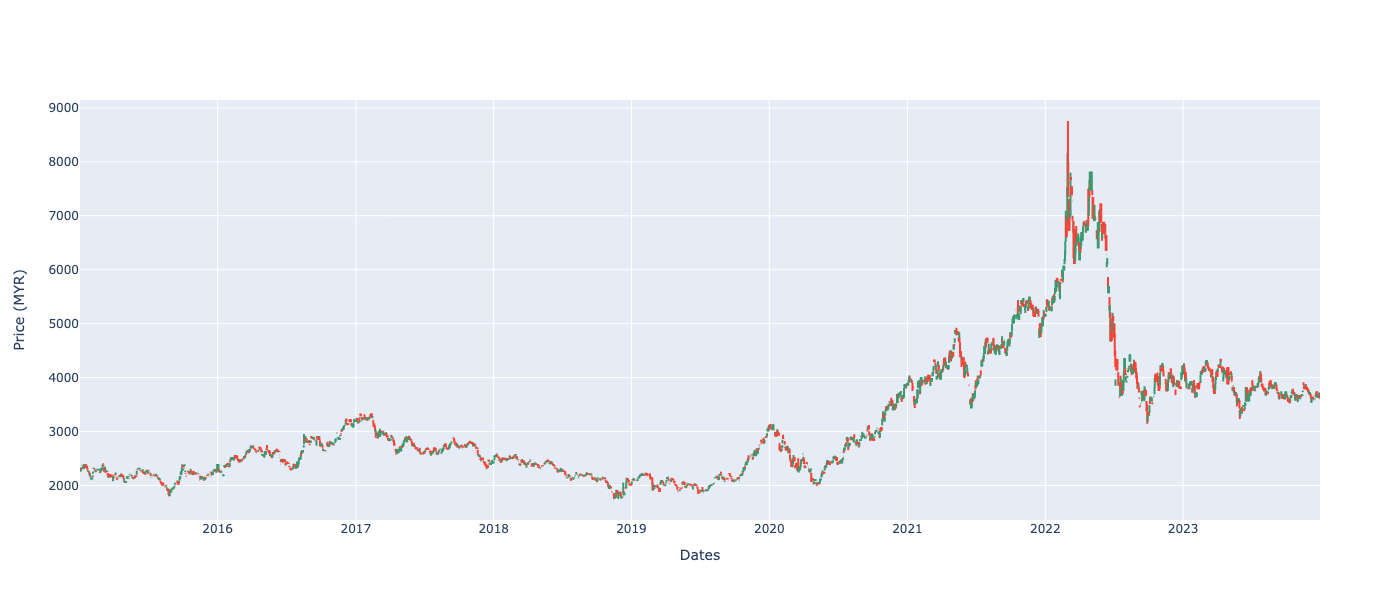

In [11]:
fig = make_subplots(rows=1, cols=1,
              #       specs=[[{"secondary_y": False}]
              #              , [{"secondary_y": False}]
              #              , [{"secondary_y": True}]
              #              ]
                           )

fig.add_trace( go.Ohlc(x=palm_analysis["date"], open=palm_analysis["open"], high=palm_analysis["high"], 
                       low=palm_analysis["low"], close=palm_analysis["close"], name="OHLC plot" )
                , row=1 , col=1 )

fig.update_xaxes(title_text="Dates", row=1, col=1)
fig.update_yaxes(title_text="Price (MYR)", row=1, col=1)

fig.update_layout(xaxis_rangeslider_visible=False, height=600, width=1400)
fig.show(renderer="png")

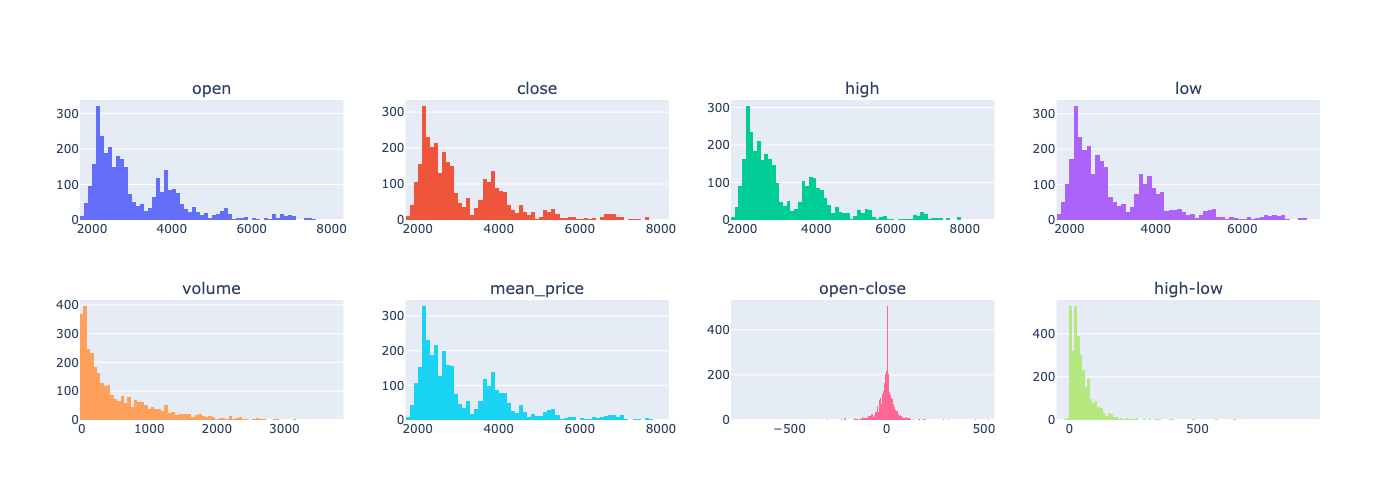

In [12]:
fig = make_subplots(rows=2, cols=4
                    , subplot_titles=("open", "close", "high", "low", "volume", "mean_price", "open-close", "high-low"))

fig.add_trace( go.Histogram(x=palm_analysis["open"]), row=1, col=1)
fig.add_trace( go.Histogram(x=palm_analysis["close"]), row=1, col=2)
fig.add_trace( go.Histogram(x=palm_analysis["high"]), row=1, col=3)
fig.add_trace( go.Histogram(x=palm_analysis["low"]), row=1, col=4)

fig.add_trace( go.Histogram(x=palm_analysis["vol."]), row=2, col=1)
fig.add_trace( go.Histogram(x=palm_analysis["mean_price"]), row=2, col=2)
fig.add_trace( go.Histogram(x=palm_analysis["open-close"]), row=2, col=3)
fig.add_trace( go.Histogram(x=palm_analysis["high-low"]), row=2, col=4)


fig.update_layout(showlegend=False, height=500, width=1400)
fig.show(renderer="png")


In [13]:
##### Decomposition 

palm_stl_decomp_7 = STL(palm_analysis['mean_price'], period=7).fit()
palm_stl_decomp_7 = pd.DataFrame(list(zip(palm_analysis["date"].to_list(),
                                          palm_analysis["mean_price"].to_list(),
                                          palm_stl_decomp_7.trend, 
                                          palm_stl_decomp_7.seasonal,
                                          palm_stl_decomp_7.resid,))
                                , columns=["date", "mean_price", "trend", "seasonal", "residual"])

palm_stl_decomp_30 = STL(palm_analysis['mean_price'], period=30).fit()
palm_stl_decomp_30 = pd.DataFrame(list(zip(palm_analysis["date"].to_list(),
                                          palm_analysis["mean_price"].to_list(),
                                          palm_stl_decomp_30.trend, 
                                          palm_stl_decomp_30.seasonal,
                                          palm_stl_decomp_30.resid,))
                                , columns=["date", "mean_price", "trend", "seasonal", "residual"])


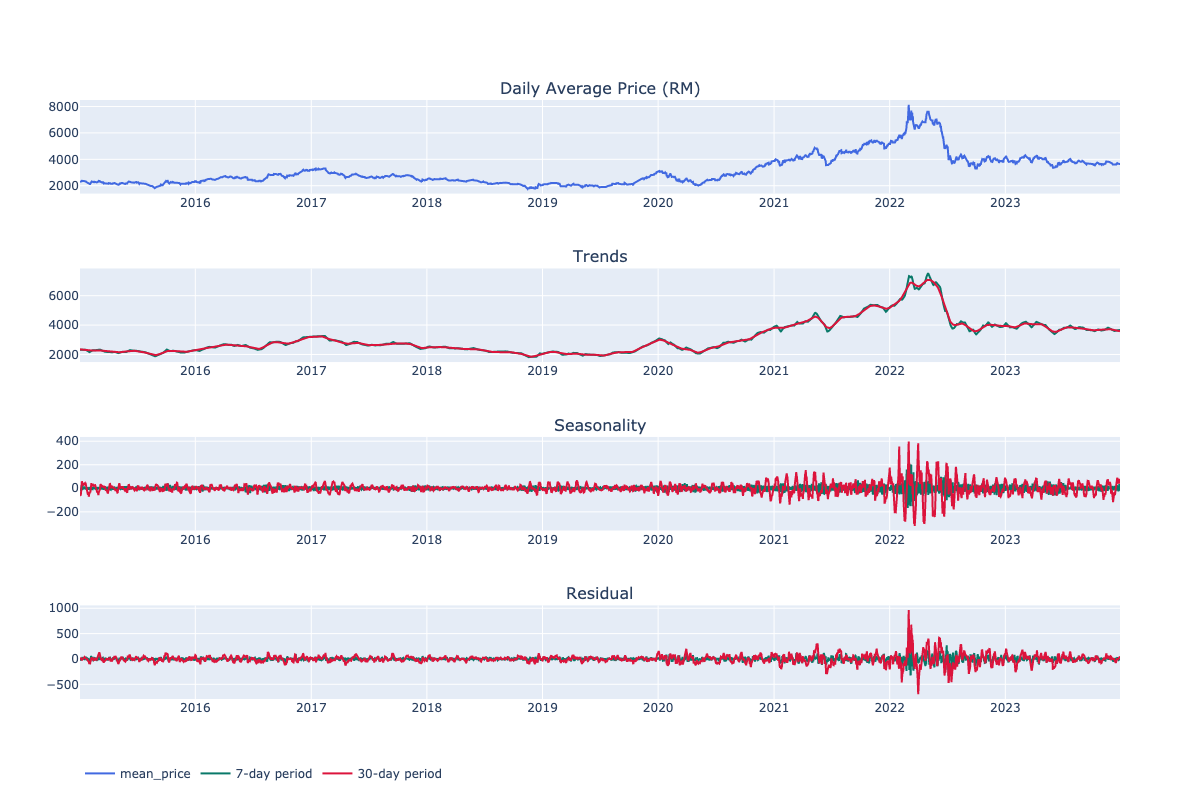

In [14]:
fig = make_subplots(rows=4, cols=1, subplot_titles=["Daily Average Price (RM)", "Trends", "Seasonality", "Residual"])

fig.add_trace( go.Scatter(x=palm_stl_decomp_7["date"], y=palm_stl_decomp_7["mean_price"], name="mean_price"
                          , line=dict(color="#4169E1")), row=1, col=1)

fig.add_trace( go.Scatter(x=palm_stl_decomp_7["date"], y=palm_stl_decomp_7["trend"], name="7-day period"
                          , line=dict(color="#097969")), row=2, col=1)
fig.add_trace( go.Scatter(x=palm_stl_decomp_7["date"], y=palm_stl_decomp_7["seasonal"], name="7-day seasonal"
                          , line=dict(color="#097969"), showlegend=False), row=3, col=1)
fig.add_trace( go.Scatter(x=palm_stl_decomp_7["date"], y=palm_stl_decomp_7["residual"], name="7-day residual"
                          , line=dict(color="#097969"), showlegend=False), row=4, col=1)

fig.add_trace( go.Scatter(x=palm_stl_decomp_30["date"], y=palm_stl_decomp_30["trend"], name="30-day period"
                          , line=dict(color="#DC143C")), row=2, col=1)
fig.add_trace( go.Scatter(x=palm_stl_decomp_30["date"], y=palm_stl_decomp_30["seasonal"], name="30-day seasonal"
                          , line=dict(color="#DC143C"), showlegend=False), row=3, col=1)
fig.add_trace( go.Scatter(x=palm_stl_decomp_30["date"], y=palm_stl_decomp_30["residual"], name="30-day residual"
                          , line=dict(color="#DC143C"), showlegend=False), row=4, col=1)


fig.update_layout(height=800, width=1200, legend=dict(orientation="h"))
fig.show(renderer="png")

In [15]:
nlags = 100

diff_df = palm_analysis[["date", "mean_price"]].copy(deep=True)
diff_df["diff_1"] = diff_df["mean_price"].diff(periods=1)
diff_df["diff_2"] = diff_df["diff_1"].diff(periods=1)
diff_df["diff_3"] = diff_df["diff_2"].diff(periods=1)
diff_df


lags = [val for val in range(nlags+1)]
mean_price_acf = acf(palm_analysis["mean_price"], nlags=nlags)
diff1_acf = acf(diff_df["diff_1"].dropna(), nlags=nlags)
diff2_acf = acf(diff_df["diff_2"].diff(periods=2).dropna(), nlags=nlags)
diff3_acf = acf(diff_df["diff_3"].diff(periods=3).dropna(), nlags=nlags)

mean_price_pacf = pacf(palm_analysis["mean_price"], nlags=nlags)
diff1_pacf = pacf(diff_df["diff_1"].dropna(), nlags=nlags)
diff2_pacf = pacf(diff_df["diff_2"].diff(periods=2).dropna(), nlags=nlags)
diff3_pacf = pacf(diff_df["diff_3"].diff(periods=3).dropna(), nlags=nlags)


acf_data = pd.DataFrame(list(zip(lags, mean_price_acf)), columns=["lags", "mean_price_acf"])
acf_data["diff1_acf"] = diff1_acf
acf_data["diff2_acf"] = diff2_acf
acf_data["mean_price_pacf"] = mean_price_pacf
acf_data["diff1_pacf"] = diff1_pacf
acf_data["diff2_pacf"] = diff2_pacf


##### Calculate acf limits
acf_limit = 2/len(acf_data)**0.5
acf_upperbound = [acf_limit]*len(acf_data)
acf_lowerbound = [-acf_limit]*len(acf_data)






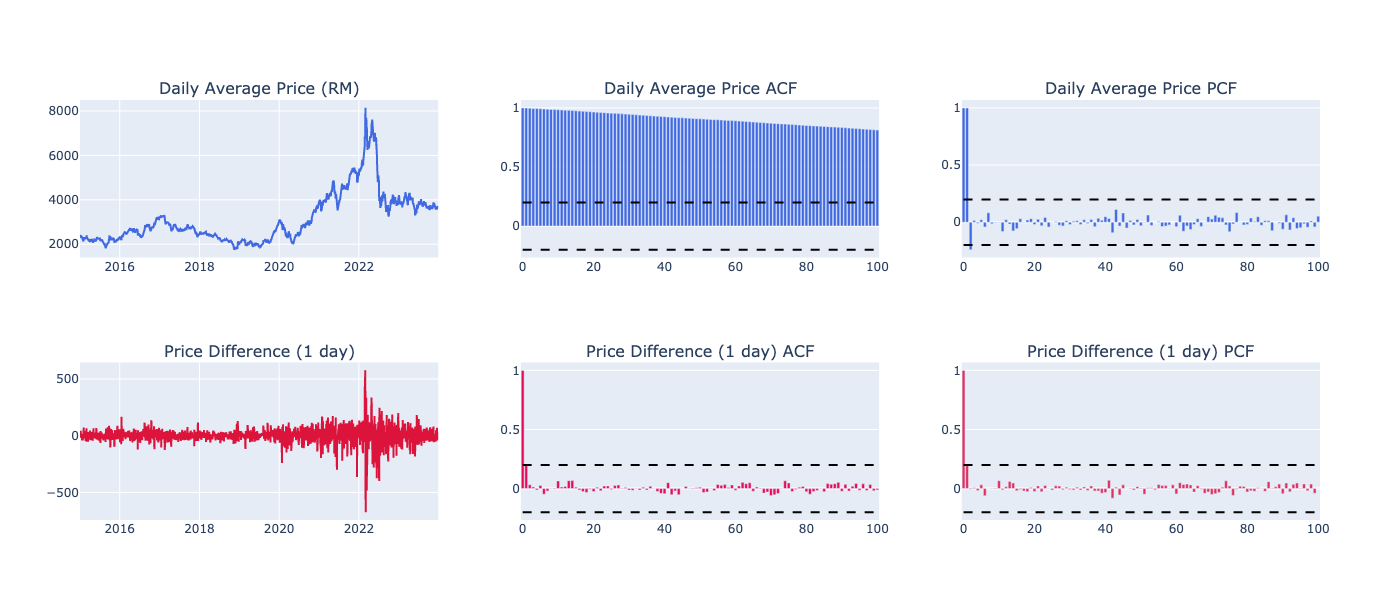

In [16]:
fig = make_subplots(rows=2, cols=3
                    , subplot_titles= ["Daily Average Price (RM)", "Daily Average Price ACF", "Daily Average Price PCF"
                                       , "Price Difference (1 day)", "Price Difference (1 day) ACF", "Price Difference (1 day) PCF"])


fig.add_trace( go.Scatter(x=diff_df["date"], y=diff_df["mean_price"], name="Daily Average Price"
                          , line=dict(color="#4169E1")), row=1, col=1)
fig.add_trace( go.Scatter(x=diff_df["date"], y=diff_df["diff_1"], name="1-day Price Difference"
                          , line=dict(color="#DC143C")), row=2, col=1)

##### Plot acf
fig.add_trace( go.Bar(x=acf_data["lags"], y=acf_data["mean_price_acf"], name="Mean Price ACF"
                      , marker=dict(color="#4169E1")), row=1, col=2)
fig.add_trace( go.Bar(x=acf_data["lags"], y=acf_data["diff1_acf"], name="diff1_acf"
                      , marker=dict(color="#E30B5C")), row=2, col=2)

##### Plot pacf
fig.add_trace( go.Bar(x=acf_data["lags"], y=acf_data["mean_price_pacf"], name="mean_price_pacf"
                      , marker=dict(color="#4169E1")), row=1, col=3)
fig.add_trace( go.Bar(x=acf_data["lags"], y=acf_data["diff1_pacf"], name="diff1_pacf"
                      , marker=dict(color="#DE3163")), row=2, col=3)


# ##### Plot acf boundary
for row_num in range(1,3):
    for col_num in range(2,4):

        fig.add_trace( go.Scatter(x=acf_data["lags"], y=acf_upperbound, 
                          line=dict(color="black", dash="dash"),  showlegend=False), row=row_num, col=col_num)
        fig.add_trace( go.Scatter(x=acf_data["lags"], y=acf_lowerbound, 
                          line=dict(color="black", dash="dash"),  showlegend=False), row=row_num, col=col_num)
        


fig.update_layout(height=600, width=1400, showlegend=False)


fig.show(renderer="png")

In [17]:

def adf_test(timeseries, name):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:3],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
        ],
    )
    return dfoutput.to_frame().rename(columns={0:name})


def kpss_test(timeseries, name):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "#Lags Used"]
    )

    return kpss_output.to_frame().rename(columns={0:name})


In [18]:

acf_tests = adf_test(palm_analysis["mean_price"], name="ave_price_adf") #adf_test(palm_analysis["mean_price"]) adfuller(palm_analysis["mean_price"], autolag="AIC")
acf_tests["ave_price_kpss"] = kpss_test(palm_analysis["mean_price"], name="ave_price_kpss")
acf_tests["first_diff_adf"] = adf_test(palm_analysis["mean_price"].diff(periods=1).dropna(), name="ave_price_adf")
acf_tests["first_diff_kpss"] = adf_test(palm_analysis["mean_price"].diff(periods=1).dropna(), name="ave_price_kpss")

acf_tests


/var/folders/pq/7mcbx8c97t90g8y2_ns4gjkr0000gn/T/ipykernel_14654/3081726724.py:15: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




,ave_price_adf,ave_price_kpss,first_diff_adf,first_diff_kpss
Test Statistic,-1.892578,4.534869,-1.303241e+01,-1.303241e+01
p-value,0.335561,0.010000,2.330268e-24,2.330268e-24
#Lags Used,14.000000,37.000000,1.300000e+01,1.300000e+01


---
---

# <center> Model Building </center>

---

In [19]:
palm_2 = palm.loc[:, :].copy(deep=True)

train_size = int(0.7*len(palm_2))

arima_train = palm_2.loc[0:train_size,["open", "close", "high", "low"]].mean(axis=1).to_list()
arima_test = palm_2.loc[train_size+1:,["open", "close", "high", "low"]].mean(axis=1).to_list()

arima_train_date, arima_test_date = palm_2.loc[0:train_size, "date"], palm_2.loc[train_size+1:, "date"]

history = arima_train
arima_prediction = []

autocorr_coef = 0
diff_coef = 1
ma_coef = 0

arima_ndays = 7

for t in range(len(arima_test)):

    ##### use statforecast
    arima_mdl = ARIMA(order=(autocorr_coef, diff_coef, ma_coef))
    arima_mdl.fit(np.array(history))

    predicted = arima_mdl.predict(h=arima_ndays)["mean"]
    arima_prediction.append(predicted[-1])

    obs = arima_test[t]
    history.append(obs)

arima_forecasts = pd.DataFrame(list(zip(arima_test_date.to_list(), arima_test, arima_prediction)), columns=["dates", "actual_values", "prediction"])
arima_forecasts["resid"] = arima_forecasts["actual_values"] - arima_forecasts["prediction"]
arima_forecasts.head(5)

,dates,actual_values,prediction,resid
0,2021-04-19,4173.25,4181.50,-8.25
1,2021-04-20,4196.50,4173.25,23.25
2,2021-04-21,4320.50,4196.50,124.00
3,2021-04-22,4418.75,4320.50,98.25
4,2021-04-23,4422.25,4418.75,3.50


In [20]:
def rnn_prep(data, ndays, target, train_portion=0.7, n_outputs=1, slope=False):

    data_len = len(data)-ndays if n_outputs==1 else len(data)-ndays-n_outputs

    ##### convert time-series to regression like problem
    x = []
    y = []


    for ii in range(data_len):
        sub_x = data.loc[ii:ii+ndays-1, :].copy(deep=True)

        if slope==True:
            sub_x_index = np.array([val for val in sub_x.index]).reshape(-1,1)
            sub_x_mean = sub_x.mean(axis=1).to_numpy().reshape(-1,1)

            lr_mdl = LinearRegression().fit(sub_x_index, sub_x_mean)
            sub_x_slope = lr_mdl.coef_
            sub_x["slope"] = [sub_x_slope[0][0]]*ndays


        x.append(sub_x)

        if n_outputs == 1:
            y.append(data.loc[ii+ndays-1, target])
        
        else:
            y.append(data.loc[ii+ndays:ii+ndays+n_outputs-1, target])

    x = np.array(x)    
    y = np.array(y)
    

    ##### split data
    train_max_index = int(train_portion*data_len)
    
    x_train = x[0:train_max_index]
    y_train = y[0:train_max_index]



    x_test = x[train_max_index:]
    y_test = y[train_max_index:]

    print(f"original data length:{len(data)}, max data length: {data_len}, train_max_index: {train_max_index}, x_train len:{len(x_train)}, x_test len:{len(x_test)}")


    return x_train, y_train, x_test, y_test

        

    


In [21]:
input_days = 14
output_days = 7

palm_mdl = palm_analysis[["open", "close", "high", "low", "vol.", "open-close", "high-low"]].copy(deep=True)
palm_mdl["open_close"] = palm_mdl["open"]/palm_mdl["close"]
palm_mdl["high_low"] = palm_mdl["high"]/palm_mdl["low"]
palm_mdl["mean"] = palm_mdl[["open", "close", "high", "low"]].mean(axis=1)


x_train, y_train, x_test, y_test = rnn_prep(data=palm_mdl[["open", "close", "high", "low", "mean"]] #, "vol.", "open-close", "high-low"
                                            , ndays=input_days, n_outputs=output_days 
                                            , train_portion=0.7
                                            , target="mean", slope=False)


x_train_shape = x_train.shape
x_test_shape = x_test.shape

y_train = np.array([[val[-1]] for val in y_train])
y_test = np.array([[val[-1]] for val in y_test])


##### reshape x_train and x_test
x_train = x_train.reshape(-1, x_train_shape[2])
x_test = x_test.reshape(-1, x_test_shape[2])


x_scaler = MinMaxScaler()
x_scaler.fit(x_train)

y_scaler = MinMaxScaler()

y_scaler.fit(y_train)


x_train = x_scaler.transform(x_train)
y_train = y_scaler.transform(y_train)

x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

#### Final reshape
x_train = x_train.reshape(x_train_shape)
x_test = x_test.reshape(x_test_shape)

val_size = int(0.2*x_train_shape[0])

x_val = x_train[-val_size:]
x_train = x_train[:-val_size]

y_val = y_train[-val_size:]
y_train = y_train[:-val_size]


original data length:3284, max data length: 3263, train_max_index: 2284, x_train len:2284, x_test len:979


In [22]:
##### model building

model = Sequential()
model.add( LSTM(500, activation="relu"
                , dropout=0.01
                , recurrent_dropout=0.01
                , input_shape=(x_train.shape[1], x_train.shape[2])) )
model.add(RepeatVector(1) )
model.add( LSTM(200, activation="relu", return_sequences=True) )
model.add( TimeDistributed( Dense(100, activation="relu")))
model.add( TimeDistributed( Dense(1)) )

my_optimizer = Adam( learning_rate=0.0005)
model.compile(optimizer=my_optimizer, loss="mae")
model.fit(x_train, y_train, epochs=500
          , validation_data=(x_val, y_val)
          , callbacks=EarlyStopping(monitor="val_loss", patience=7, min_delta=0))

clear_output(wait=True)

model.summary()


Epoch 1/500


In [ ]:
loss_hist = model.history.history["loss"]
val_hist = model.history.history["val_loss"]
epochs = [val+1 for val in range(len(loss_hist))]

fig = make_subplots(rows=1, cols=1)

fig.add_trace( go.Scatter(x=epochs, y=loss_hist, name="training set"))
fig.add_trace( go.Scatter(x=epochs, y=val_hist, name="validation set"))

fig.update_xaxes(title_text="epochs")
fig.update_yaxes(title_text="mae")
fig.update_layout(width=1200, height=300, legend=dict(orientation="h"))
fig.show(render="png")

In [ ]:

############################################## Checking model on training data #################################################
rnn_train = model.predict(x_train)
# rnn_train = y_scaler.inverse_transform(rnn_train.reshape(rnn_train.shape[0], output_days))
rnn_train = y_scaler.inverse_transform(rnn_train.reshape(rnn_train.shape[0], 1))
rnn_train = rnn_train.reshape(1,-1)[0]

palm_train = palm.loc[0:x_train.shape[0]-1, ["date"]].reset_index(drop=True)
palm_train["mean"] = palm_mdl.loc[0:x_train.shape[0]-1, ["mean"]].reset_index(drop=True)

palm_train["prediction"] = rnn_train
palm_train["resid"] = palm_train["mean"] - palm_train["prediction"]
palm_train



############################################## Checking model on testing data #################################################
rnn_test =  model.predict(x_test)
# rnn_test = y_scaler.inverse_transform(rnn_test.reshape(rnn_test.shape[0], output_days))
rnn_test = y_scaler.inverse_transform(rnn_test.reshape(rnn_test.shape[0], 1))
rnn_test = rnn_test.reshape(1,-1)[0]
rnn_test

palm_prediction = palm.loc[len(palm)-len(rnn_test):, ["date"]].reset_index(drop=True)
palm_prediction["mean"] = palm_mdl.loc[len(palm_mdl)-len(rnn_test):, ["mean"]].reset_index(drop=True)

palm_prediction

palm_prediction["prediction"] = rnn_test
palm_prediction["resid"] = palm_prediction["mean"] - palm_prediction["prediction"]

palm_prediction.head(3)

# palm_train

31/31 [==============================] - 1s 20ms/step


,date,mean,prediction,resid
0,2021-04-25,4422.25,4091.441406,330.808594
1,2021-04-26,4372.00,4088.831787,283.168213
2,2021-04-27,4435.75,4083.146484,352.603516


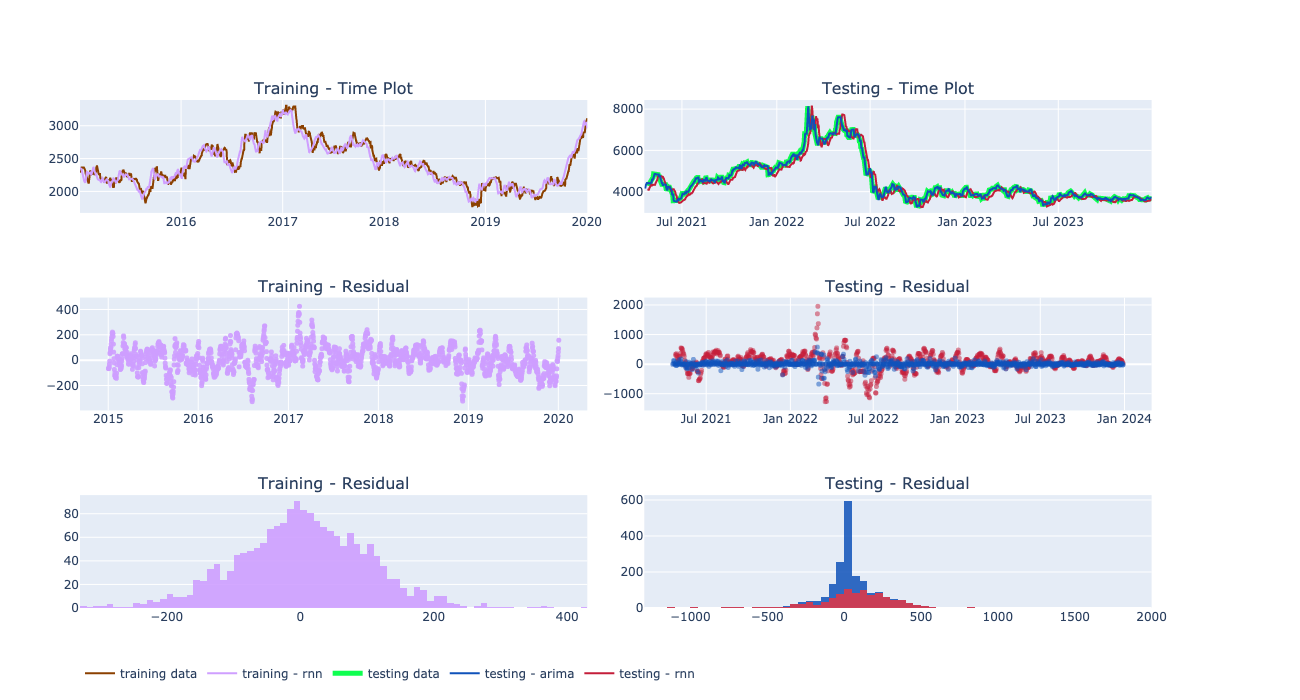

In [ ]:
fig = make_subplots(rows=3, cols=2
                    , horizontal_spacing=0.05
                    , specs=[[{"secondary_y":True}, {"secondary_y":True}], [{"secondary_y":True}, {"secondary_y":True}], [{"secondary_y":True}, {"secondary_y":True}]]
                    , subplot_titles=("Training - Time Plot", "Testing - Time Plot", "Training - Residual"
                                      , "Testing - Residual", "Training - Residual", "Testing - Residual"))

####### for training set
fig.add_trace( go.Scatter(x=palm_train["date"], y=palm_train["mean"]
                          , line=dict(color="#8B4000"), name="training data", legendrank=5), row=1, col=1)
fig.add_trace( go.Scatter(x=palm_train["date"], y=palm_train["prediction"]
                          , line=dict(color="#CF9FFF"), name="training - rnn", legendrank=4), row=1, col=1)
fig.add_trace( go.Scatter(x=palm_train["date"], y=palm_train["resid"]
                          ,mode="markers", marker=dict(size=5, color="#CF9FFF", opacity=0.9), name="training data - resid"
                          , showlegend=False), row=2, col=1)
fig.add_trace( go.Histogram(x=palm_train["resid"], marker=dict(color="#CF9FFF", opacity=0.9), name="training data - resid"
                            , showlegend=False), row=3, col=1)


###### for testing set
fig.add_trace( go.Scatter(x=palm_prediction["date"], y=palm_prediction["mean"]
                          , line=dict(color="#0FFF50", width=5) ,name="testing data", legendrank=3), row=1, col=2)

fig.add_trace( go.Scatter(x=palm_prediction["date"], y=palm_prediction["prediction"]
                          ,line=dict(color="#C41E3A"), name="testing - rnn", legendrank=1), row=1, col=2)
fig.add_trace( go.Scatter(x=arima_forecasts["dates"], y=arima_forecasts["prediction"]
                          , line=dict(color="#0F52BA"), name="testing - arima", legendrank=2), row=1, col=2)

fig.add_trace( go.Scatter(x=palm_prediction["date"], y=palm_prediction["resid"], mode="markers"
                          ,marker=dict(size=5, color="#C41E3A", opacity=0.5), name="resid - rnn_test"
                          , showlegend=False), row=2, col=2)
fig.add_trace( go.Scatter(x=arima_forecasts["dates"], y=arima_forecasts["resid"], mode="markers"
                          ,marker=dict(size=5, color="#0F52BA", opacity=0.5), name="resid - arima"
                          , showlegend=False), row=2, col=2)

fig.add_trace( go.Histogram(x=palm_prediction["resid"], marker=dict(color="#C41E3A", opacity=0.85), name="resid - rnn test"
                            , showlegend=False), row=3, col=2)
fig.add_trace( go.Histogram(x=arima_forecasts["resid"], marker=dict(color="#0F52BA", opacity=0.85), name="resid - arima"
                            , showlegend=False), row=3, col=2)


fig.update_layout(legend=dict(orientation="h")
                  , height=700, width=1300
                  , barmode="stack")
fig.show(renderer="png")

In [ ]:
arima_rmse = arima_forecasts["resid"]**2
arima_rmse = arima_rmse.mean()**0.5
arima_mae = arima_forecasts["resid"].abs().mean()
arima_mape = np.mean(np.abs(arima_forecasts["resid"]/arima_forecasts["actual_values"]))*100

rnn_train_rmse = palm_train["resid"]**2
rnn_train_rmse = rnn_train_rmse.mean()**0.5
rnn_train_mae = palm_train["resid"].abs().mean()
rnn_train_mape = np.mean(np.abs(palm_train["resid"]/palm_train["mean"]))*100

rnn_test_rmse = palm_prediction["resid"]**2
rnn_test_rmse = rnn_test_rmse.mean()**0.5
rnn_test_mae = palm_prediction["resid"].abs().mean()
rnn_test_mape = np.mean(np.abs(palm_prediction["resid"]/palm_prediction["mean"]))*100

data_name = ["arima", "rnn_train", "rnn_test"]
rmse_values = [arima_rmse, rnn_train_rmse, rnn_test_rmse]
mae_values = [arima_mae, rnn_train_mae, rnn_test_mae]
mape_values = [arima_mape, rnn_train_mape, rnn_test_mape]

result_summary = pd.DataFrame(list(zip(data_name, rmse_values, mae_values, mape_values)), columns=["data", "rmse", "mae", "mape"])
result_summary

,data,rmse,mae,mape
0,arima,84.956437,46.290863,0.993257
1,rnn_train,102.442120,80.266179,3.367949
2,rnn_test,441.396184,270.741149,5.495682


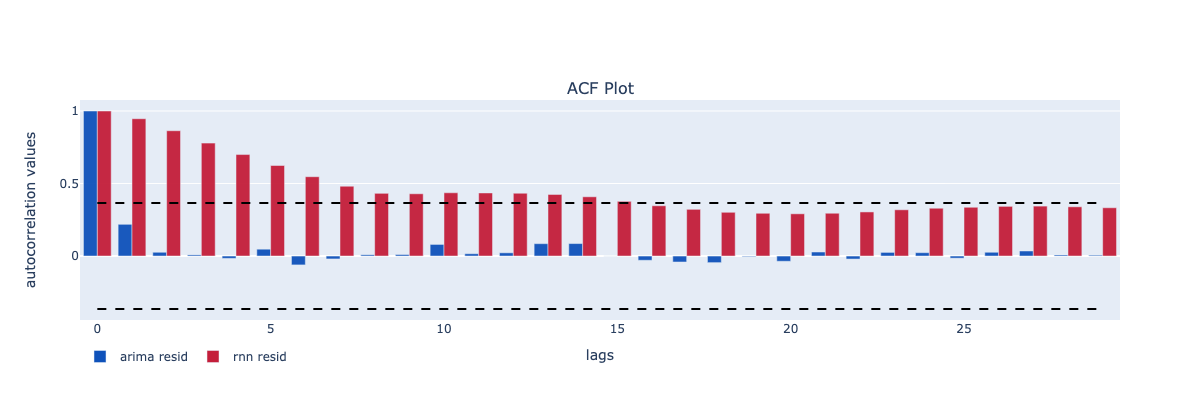

In [ ]:
arima_resid_acf = acf(arima_forecasts["resid"])
rnn_resid_acf = acf(palm_prediction["resid"])
acf_lags = [val for val in range(len(arima_resid_acf+1))]

mdl_acf_results = pd.DataFrame(list(zip(acf_lags, arima_resid_acf, rnn_resid_acf)), columns=["lags", "arima_resid", "rnn_resid"])

##### Calculate acf limits
mdl_acf_limit = 2/len(mdl_acf_results)**0.5
mdl_acf_upperbound = [mdl_acf_limit]*len(mdl_acf_results)
mdl_acf_lowerbound = [-mdl_acf_limit]*len(mdl_acf_results)

fig = make_subplots(rows=1, cols=1, subplot_titles=["ACF Plot"])

fig.add_trace( go.Bar(x=mdl_acf_results["lags"], y=mdl_acf_results["arima_resid"]
                          ,marker=dict(color="#0F52BA", opacity=0.95), name="arima resid"))
fig.add_trace( go.Bar(x=mdl_acf_results["lags"], y=mdl_acf_results["rnn_resid"]
                          ,marker=dict(color="#C41E3A", opacity=0.95),name="rnn resid"))


fig.add_trace( go.Scatter(x=mdl_acf_results["lags"], y=mdl_acf_upperbound, 
                    line=dict(color="black", dash="dash"),  showlegend=False), row=1, col=1)
fig.add_trace( go.Scatter(x=mdl_acf_results["lags"], y=mdl_acf_lowerbound, 
                    line=dict(color="black", dash="dash"),  showlegend=False), row=1, col=1)

fig.update_xaxes(title_text="lags")
fig.update_yaxes(title_text="autocorrelation values")

fig.update_layout(legend=dict(orientation="h")
                  , height=400, width=1200)
fig.show(renderer="png")
